In [51]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
def getMirrored(image):
    mir1 = np.flip(image, 0)
    mir2 = np.flip(image, 1)
    mir3 = np.flip(image, (0, 1))
    return [mir1, mir2, mir3]

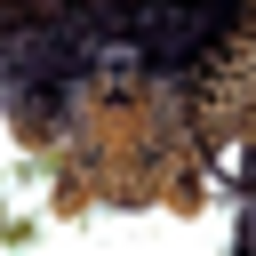

In [53]:
# Чтение тренировочной выборки (обучающих данных)
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')

# Чтение тестовой выборки (тестовых данных)
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
# Переформируем выборку и оставляем только 3 указанных класса.
CLASSES = [73, 12, 42]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

for i in range(len(train_X)):
    image = train_X[i]
    train_y = np.append(train_y, [train_y[i], train_y[i], train_y[i]])
    train_X = np.append(train_X, getMirrored(image), axis=0)
    
test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

for i in range(len(test_X)):
    image = test_X[i]
    test_y = np.append(test_y, [test_y[i], test_y[i], test_y[i]])
    test_X = np.append(test_X, getMirrored(image), axis=0)

Image.fromarray(train_X[1650]).resize((256,256))

In [54]:
# Указываем размер батча 
batch_size = 100

dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x1723bddc0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x17fa1e250>}

In [55]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

# Создадим простой многослойный перцептрон с одним скрытым слоем и функцией нелинейности.
# Количество скрытых слоев можно изменять.
class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size), 
            nn.ReLU(), # активационная функция
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [56]:
# Функция потерь
criterion = nn.CrossEntropyLoss()
# Оптимизатор
# lr - шаг обучения. Данный параметр можно изменять.
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [57]:
# Укажем количество эпох. 
# Увеличение количества эпох приводит к увеличению времени работы программы.
# Чем больше эпох мы обучаем, тем точнее обучается модель, но есть риск наступления переобучения.

EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()

        #Для обновления параметров нейронной сети используется метод step, применённый к экземпляру класса оптимизатора.
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0

    #Для перевода модели в состояние проверки необходимо вызвать метод eval. После чего модель готова для проверки.
    model.eval()

    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

[1,    60] loss: 0.797
[1,    12] val loss: 0.799
[2,    60] loss: 0.631
[2,    12] val loss: 0.754
[3,    60] loss: 0.583
[3,    12] val loss: 0.736
[4,    60] loss: 0.557
[4,    12] val loss: 0.723
[5,    60] loss: 0.537
[5,    12] val loss: 0.717
[6,    60] loss: 0.520
[6,    12] val loss: 0.714
[7,    60] loss: 0.509
[7,    12] val loss: 0.705
[8,    60] loss: 0.497
[8,    12] val loss: 0.695
[9,    60] loss: 0.486
[9,    12] val loss: 0.691
[10,    60] loss: 0.476
[10,    12] val loss: 0.674
[11,    60] loss: 0.468
[11,    12] val loss: 0.670
[12,    60] loss: 0.460
[12,    12] val loss: 0.669
[13,    60] loss: 0.453
[13,    12] val loss: 0.674
[14,    60] loss: 0.445
[14,    12] val loss: 0.672
[15,    60] loss: 0.440
[15,    12] val loss: 0.666
[16,    60] loss: 0.432
[16,    12] val loss: 0.658
[17,    60] loss: 0.428
[17,    12] val loss: 0.667
[18,    60] loss: 0.421
[18,    12] val loss: 0.674
[19,    60] loss: 0.416
[19,    12] val loss: 0.662
[20,    60] loss: 0.411
[20,  

In [58]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Выведем отчет о точности обучения модели.
        # На тестовых данных модель может обучиться до 100%. Результ, который показывается на тренировочной выборке, хуже.
        
        # Выведем метрики ранжирования для тестовой и обучающей выборки.
        print(part)

        # Значения выводятся с точность 4 знака после запятой.

        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          73     0.9950    0.9955    0.9953      2000
          12     0.9935    0.9980    0.9958      2000
          42     0.9945    0.9895    0.9920      2000

    accuracy                         0.9943      6000
   macro avg     0.9943    0.9943    0.9943      6000
weighted avg     0.9943    0.9943    0.9943      6000

--------------------------------------------------
test
              precision    recall  f1-score   support

          73     0.7568    0.7000    0.7273       400
          12     0.7083    0.7225    0.7153       400
          42     0.7512    0.7925    0.7713       400

    accuracy                         0.7383      1200
   macro avg     0.7388    0.7383    0.7380      1200
weighted avg     0.7388    0.7383    0.7380      1200

--------------------------------------------------


In [59]:
# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_lnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [61]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to('cpu')
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_LNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})